In [1]:
from os import listdir
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from numpy import load, ones, zeros, asarray, savez_compressed
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
from matplotlib import pyplot as plt


init = RandomNormal(mean=0.0, stddev=0.02, seed=42)


# load all images in two directories ("before" and "after") into memory as pairs
def load_image_pairs(before_path, after_path, size=(256, 256)):
    src_list, tar_list = list(), list()
    # enumerate filenames in the "before" directory, assume all are images with matching names in "after"
    for filename in listdir(before_path):
        # Load and resize the "before" image
        before_image = load_img(before_path + filename, target_size=size)
        before_image = img_to_array(before_image)
        
        # Load and resize the matching "after" image
        after_image = load_img(after_path + filename, target_size=size)
        after_image = img_to_array(after_image)
        
        # Append to the lists
        src_list.append(before_image)
        tar_list.append(after_image)
        
    # Convert lists to numpy arrays
    return [asarray(src_list), asarray(tar_list)]


In [2]:
# Function to load paired images from "before" and "after" directories
def load_image_pairs(before_path, after_path, size=(256, 256)):
    src_list, tar_list = list(), list()
    # Loop through filenames in the "before" directory, assuming matching filenames in "after" directory
    for filename in listdir(before_path):
        # Load and resize "before" image
        before_image = load_img(before_path + filename, target_size=size)
        before_image = img_to_array(before_image)
        
        # Load and resize matching "after" image
        after_image = load_img(after_path + filename, target_size=size)
        after_image = img_to_array(after_image)
        
        # Append each image to the respective list
        src_list.append(before_image)
        tar_list.append(after_image)
        
    # Convert lists to numpy arrays
    return [asarray(src_list), asarray(tar_list)]

# Paths to your "before" and "after" directories
before_path = 'before/'
after_path = 'after/'

# Load the dataset
[src_images, tar_images] = load_image_pairs(before_path, after_path)
print('Loaded: ', src_images.shape, tar_images.shape)

# Save dataset as a compressed numpy array
filename = 'before_after_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)


Loaded:  (712, 256, 256, 3) (712, 256, 256, 3)
Saved dataset:  before_after_256.npz


Loaded:  (712, 256, 256, 3) (712, 256, 256, 3)


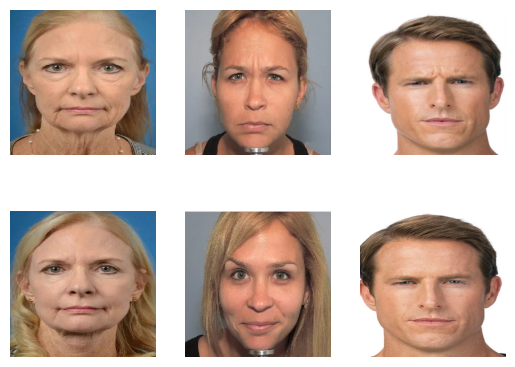

In [3]:
# Load the prepared dataset
data = load('before_after_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

# Plot source ("before") images
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))

# Plot target ("after") images
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))

plt.show()


In [4]:


# define the discriminator model
def define_discriminator(image_shape):
    # source image input (e.g., "before")
    in_src_image = Input(shape=image_shape)
    # target image input (e.g., "after")
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, loss_weights=[0.5])
    return model


In [5]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):

    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):

    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):

    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model


In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image input
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, loss_weights=[1, 100])
    return model


In [7]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


In [8]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y


In [9]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


In [10]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.tf' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))


In [11]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=170, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)


In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Load dataset
dataset = load_real_samples('before_after_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# Define input shape based on the dataset
image_shape = dataset[0].shape[1:]

# Load the saved generator model (skip compiling it here)
g_model = tf.keras.models.load_model('model_035600.tf')

# Reinitialize the discriminator model
d_model = define_discriminator(image_shape)

# Rebuild the GAN model
gan_model = define_gan(g_model, d_model, image_shape)

# Compile the GAN model explicitly
gan_model.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss=['binary_crossentropy', 'mae'],
    loss_weights=[1, 100]
)

# Continue training
train(d_model, g_model, gan_model, dataset)


Loaded (712, 256, 256, 3) (712, 256, 256, 3)



KeyboardInterrupt



In [16]:

import tensorflow as tf 
# Load the re-saved generator model
g_model = tf.keras.models.load_model('temp_g_model_with_training_config.tf')

# Reinitialize the discriminator model
d_model = define_discriminator(image_shape)

# Rebuild and compile the GAN model with g_model and d_model
gan_model = define_gan(g_model, d_model, image_shape)
gan_model.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss=['binary_crossentropy', 'mae'],
    loss_weights=[1, 100]
)

# Continue training
train(d_model, g_model, gan_model, dataset)


1/1 [==============================] - 0s 317ms/step
>1, d1[0.237] d2[1.363] g[7.765]
1/1 [==============================] - 0s 20ms/step
>2, d1[0.276] d2[0.940] g[8.700]
1/1 [==============================] - 0s 20ms/step
>3, d1[0.324] d2[0.979] g[10.790]
1/1 [==============================] - 0s 21ms/step
>4, d1[0.329] d2[0.900] g[8.453]
1/1 [==============================] - 0s 19ms/step
>5, d1[0.646] d2[0.688] g[7.314]
1/1 [==============================] - 0s 20ms/step
>6, d1[0.502] d2[0.572] g[8.196]
1/1 [==============================] - 0s 21ms/step
>7, d1[0.435] d2[0.566] g[11.191]
1/1 [==============================] - 0s 19ms/step
>8, d1[0.401] d2[0.492] g[9.710]
1/1 [==============================] - 0s 21ms/step
>9, d1[0.460] d2[0.487] g[8.867]
1/1 [==============================] - 0s 20ms/step
>10, d1[0.458] d2[0.445] g[7.862]
1/1 [==============================] - 0s 21ms/step
>11, d1[0.426] d2[0.472] g[9.866]
1/1 [==============================] - 0s 19ms/step
>12, d1[

INFO:tensorflow:Assets written to: model_007120.tf\assets


INFO:tensorflow:Assets written to: model_007120.tf\assets


>Saved: plot_007120.png and model_007120.tf
1/1 [==============================] - 0s 23ms/step
>7121, d1[0.348] d2[0.355] g[5.600]
1/1 [==============================] - 0s 23ms/step
>7122, d1[0.356] d2[0.351] g[4.693]
1/1 [==============================] - 0s 22ms/step
>7123, d1[0.351] d2[0.349] g[22.968]
1/1 [==============================] - 0s 25ms/step
>7124, d1[0.349] d2[0.368] g[9.103]
1/1 [==============================] - 0s 22ms/step
>7125, d1[0.352] d2[0.353] g[4.327]
1/1 [==============================] - 0s 22ms/step
>7126, d1[0.350] d2[0.354] g[5.886]
1/1 [==============================] - 0s 22ms/step
>7127, d1[0.351] d2[0.352] g[7.163]
1/1 [==============================] - 0s 22ms/step
>7128, d1[0.351] d2[0.362] g[9.000]
1/1 [==============================] - 0s 23ms/step
>7129, d1[0.350] d2[0.361] g[5.154]
1/1 [==============================] - 0s 22ms/step
>7130, d1[0.347] d2[0.355] g[8.918]
1/1 [==============================] - 0s 22ms/step
>7131, d1[0.355] d2[0.3

INFO:tensorflow:Assets written to: model_014240.tf\assets


INFO:tensorflow:Assets written to: model_014240.tf\assets


>Saved: plot_014240.png and model_014240.tf
1/1 [==============================] - 0s 26ms/step
>14241, d1[0.350] d2[0.350] g[5.978]
1/1 [==============================] - 0s 26ms/step
>14242, d1[0.348] d2[0.353] g[5.749]
1/1 [==============================] - 0s 24ms/step
>14243, d1[0.349] d2[0.351] g[7.685]
1/1 [==============================] - 0s 25ms/step
>14244, d1[0.349] d2[0.353] g[7.129]
1/1 [==============================] - 0s 25ms/step
>14245, d1[0.349] d2[0.353] g[7.130]
1/1 [==============================] - 0s 24ms/step
>14246, d1[0.347] d2[0.355] g[6.133]
1/1 [==============================] - 0s 25ms/step
>14247, d1[0.350] d2[0.349] g[6.647]
1/1 [==============================] - 0s 25ms/step
>14248, d1[0.348] d2[0.352] g[6.910]
1/1 [==============================] - 0s 25ms/step
>14249, d1[0.348] d2[0.352] g[7.089]
1/1 [==============================] - 0s 25ms/step
>14250, d1[0.351] d2[0.353] g[7.302]
1/1 [==============================] - 0s 24ms/step
>14251, d1[0.3

INFO:tensorflow:Assets written to: model_021360.tf\assets


INFO:tensorflow:Assets written to: model_021360.tf\assets


>Saved: plot_021360.png and model_021360.tf
1/1 [==============================] - 0s 33ms/step
>21361, d1[0.350] d2[0.349] g[4.568]
1/1 [==============================] - 0s 28ms/step
>21362, d1[0.349] d2[0.350] g[6.231]
1/1 [==============================] - 0s 30ms/step
>21363, d1[0.348] d2[0.351] g[6.461]
1/1 [==============================] - 0s 30ms/step
>21364, d1[0.350] d2[0.349] g[5.922]
1/1 [==============================] - 0s 28ms/step
>21365, d1[0.347] d2[0.353] g[5.842]
1/1 [==============================] - 0s 30ms/step
>21366, d1[0.349] d2[0.349] g[4.962]
1/1 [==============================] - 0s 27ms/step
>21367, d1[0.350] d2[0.349] g[6.459]
1/1 [==============================] - 0s 29ms/step
>21368, d1[0.349] d2[0.349] g[5.305]
1/1 [==============================] - 0s 30ms/step
>21369, d1[0.347] d2[0.351] g[7.267]
1/1 [==============================] - 0s 30ms/step
>21370, d1[0.349] d2[0.349] g[5.821]
1/1 [==============================] - 0s 29ms/step
>21371, d1[0.3

INFO:tensorflow:Assets written to: model_028480.tf\assets


INFO:tensorflow:Assets written to: model_028480.tf\assets


>Saved: plot_028480.png and model_028480.tf
1/1 [==============================] - 0s 34ms/step
>28481, d1[0.346] d2[0.350] g[3.491]
1/1 [==============================] - 0s 36ms/step
>28482, d1[0.347] d2[0.350] g[5.096]
1/1 [==============================] - 0s 37ms/step
>28483, d1[0.346] d2[0.350] g[3.512]
1/1 [==============================] - 0s 37ms/step
>28484, d1[0.347] d2[0.350] g[6.161]
1/1 [==============================] - 0s 36ms/step
>28485, d1[0.346] d2[0.350] g[5.001]
1/1 [==============================] - 0s 37ms/step
>28486, d1[0.346] d2[0.350] g[5.938]
1/1 [==============================] - 0s 36ms/step
>28487, d1[0.346] d2[0.350] g[7.012]
1/1 [==============================] - 0s 36ms/step
>28488, d1[0.346] d2[0.350] g[6.181]
1/1 [==============================] - 0s 38ms/step
>28489, d1[0.346] d2[0.350] g[4.386]
1/1 [==============================] - 0s 35ms/step
>28490, d1[0.346] d2[0.350] g[6.850]
1/1 [==============================] - 0s 39ms/step
>28491, d1[0.3

KeyboardInterrupt: 